#**M4 Wisconsin Breast Cancer Dataset**

This notebook examines classifier solutions for the Wisconsin Breast Cancer Dataset, available here: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)

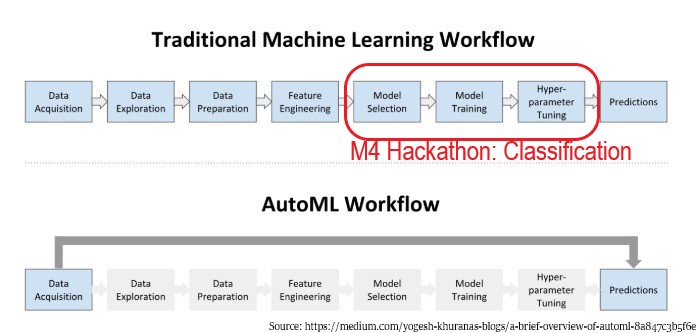

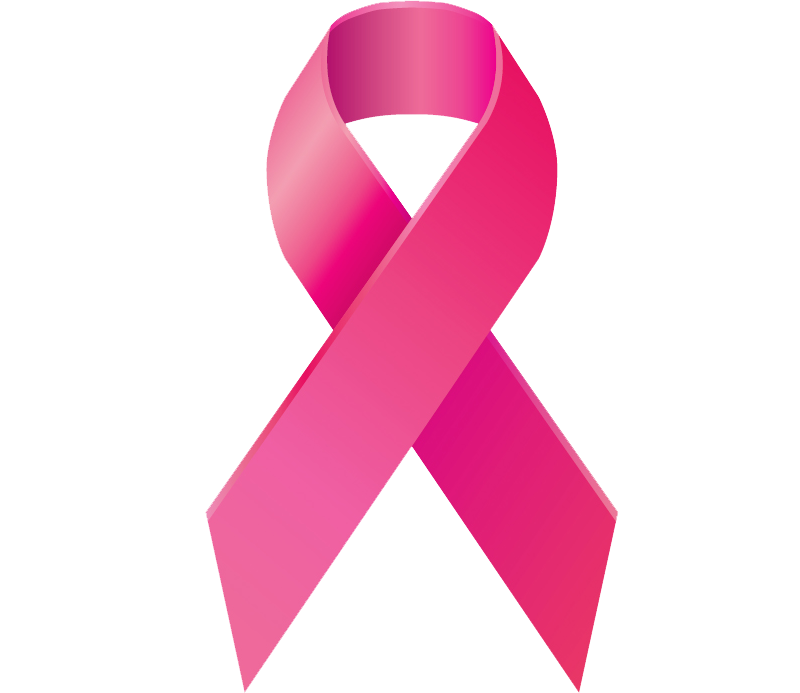

#**Table of Contents**
* Business Problem
* Executive SUmmary (BLUF)
* Conclusions from the Preprocessing Notebook
* Libraries
* Data
* Separate Predictors & Target, Encode Target
* Skewness COrrection
* Outliers
* Holdout Sample
* Scaling
* Logistic Regression Classifier
* Other Classifiers
* Oversampling with SMOTE
* Conclusion


#**Business Problem**
##Business Problem##
Breast cancer affects both females and males. The rate of occurrence is much higher in females, but [males have a lower five-year survival rate](https://https://www.cancer.gov/news-events/cancer-currents-blog/2019/male-breast-cancer-higher-mortality#:~:text=In%20the%20study%2C%20the%205,JAMA%20Oncology%20on%20September%2019.). Breast cancer is the second leading cause of death for women in the US, after lung cancer. Over 44,000 women, and over 500 males are [expected](https://www.cancer.net/cancer-types/breast-cancer/statistics#:~:text=An%20estimated%202%2C650%20men%20in,after%20the%20cancer%20is%20found.) to die of breast cancer in the US this year.

An international pathology group is seeking to add a breast mass classifier to initially serve as a decision aid for specialist diagnosis, and to progressively improve the classifier over time. High-quality and high-speed diagnosis is a critical need as diagnoses often have to be rendered while a patient is under anaesthetic.

False negatives are cases that are undiagnosed and may lead to a quicker death. False positives may endure unnecessary radical surgery, lung-damaging radiation, chemo, and other treatments.

##Metrics##
AUC is chosen as the primary aggregate metric as it provides an assessment of how well a classifier separates the categories of a classifier. Accuracy and recall will also be considered. Accuracy assesses the overall percentage of error, and recall assesses tha rate at which instances that are truly positive (malignant) are correctly classified. We want to minimize false negatives as these instances may go untreated and lead to quicker death. Overall, we need very high AUC, accuracy and recall scores (hopefully above 99%) as this is literally a matter of life and death. 

Propensities in the interval [0.3,0.7] will be reported to bring attention to masses that are hard to classify. Propensities will be reported for those instances for which a human specialist diagnosis differs from that of the recommended classifier(s).

#**Executive Summary (BLUF)**
Several models with AUC above 99% and recall above 95% were obtained. A random forest model was developed with AUC mean of 0.992, mean recall of 0.928, and mean accuracy of 0.973. A logistic regression model provided similar performance. 

Analysis shows about 7% of the instances have propensities in the [0.3,0.7] range, but the misclassified instances vary across the classifiers.

These classifiers will be solid decision aids. The natural next step, given the criticality of the use case, is to build models using a lot more data, in an effort to squeeze out errors (especially false negatives) altogether.

#**Conclusions from the Preprocessing Notebook**
- No missing value or duplicate pre-processing needed
- Corrected for skewness
- Winsorized outliers in order to preserve data
- Two to three principal components may be sufficient to build a satisfactory model
- The data set is unbalanced (37.26% of the instances are for malignant masses). We can try building the models using the unbalanced data, or we can try SMOTE. There is likely too little data to contemplate undersampling. 

#**Libraries**

In [2]:
# Basic libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import scipy.stats as ss
import math
from matplotlib.colors import ListedColormap

In [3]:
# LightGBM Library
!pip install lightgbm
from lightgbm import LGBMClassifier

In [4]:
# sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss, balanced_accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

In [5]:
# mblearn library
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.datasets import load_breast_cancer

#**Data**

In [6]:
# Read in data from the sklearn library
cancer = load_breast_cancer()

# Column 1 is the target (1=malignant, 0 = benign)
df = pd.DataFrame(np.c_[cancer['target'],cancer['data']], columns = np.append(['target'],cancer['feature_names']))

# Plot the last 5 rows of the data
df.tail()

,target,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
564,0.0,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,0.0,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,0.0,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,0.0,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,1.0,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


#**Separate Predictors & Target, Encode Target**


In [7]:
# Create binary-encoded target column (y)
y = df.loc[:,'target']
#Drop ID and old target column to get predictors (X)
X = df.drop(columns='target')

#**Skewness Correction**

In [8]:
# Code for skewness correction (see source below)
# Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution 

# -*- coding: utf-8 -*-
"""


"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness



def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()
                

    return DF


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'target' . Skewness = -0.53


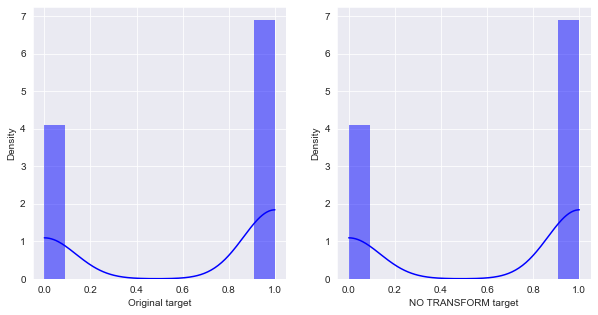


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'mean radius' . Skewness = 0.94


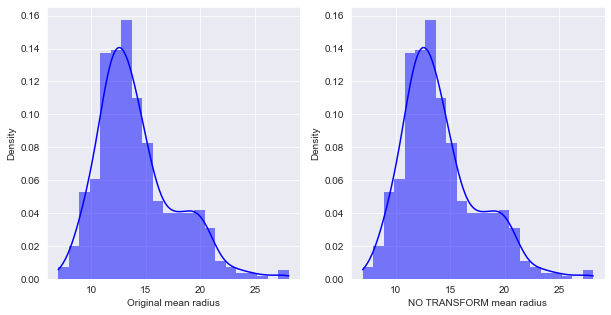


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'mean texture' . Skewness = 0.65


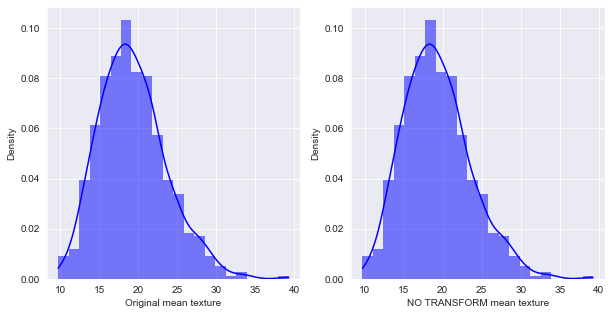


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'mean perimeter' . Skewness = 0.99


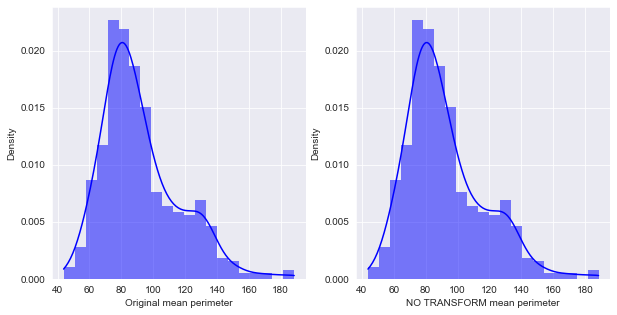


 ------------------------------------------------------

 'mean area' had 'positive' skewness of 1.65

 Transformation yielded skewness of 0.01


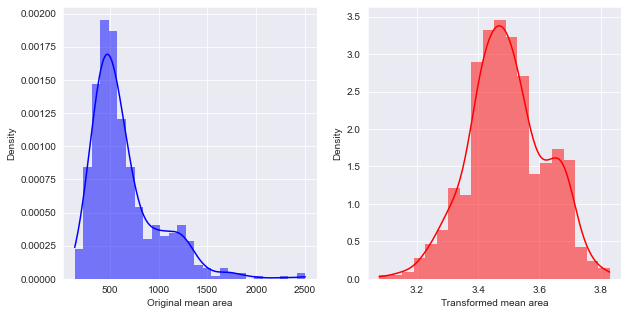


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'mean smoothness' . Skewness = 0.46


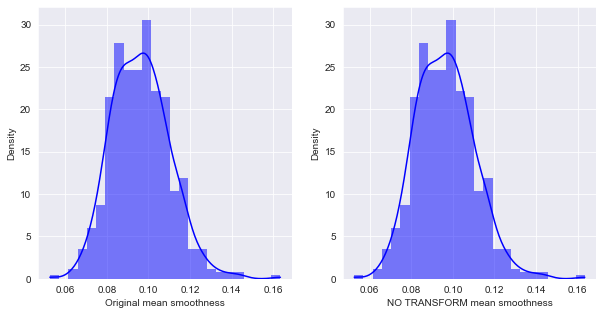


 ------------------------------------------------------

 'mean compactness' had 'positive' skewness of 1.19

 Transformation yielded skewness of -0.00


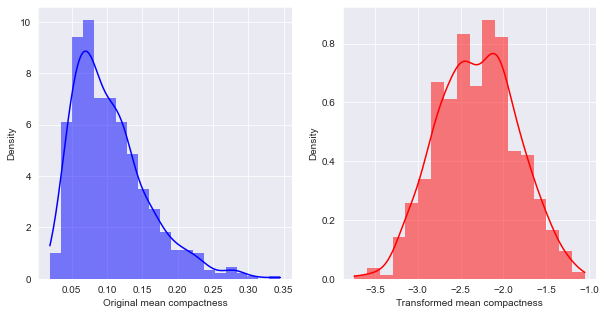


 ------------------------------------------------------

 'mean concavity' had 'positive' skewness of 1.40

 Transformation yielded skewness of -0.02


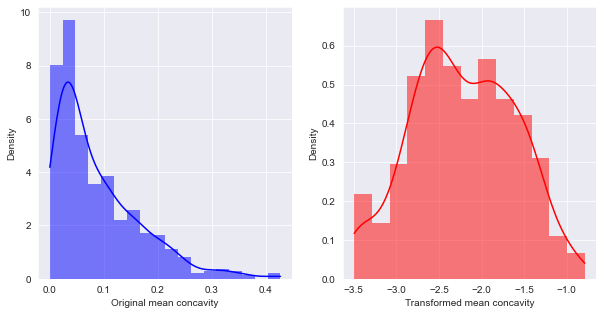


 ------------------------------------------------------

 'mean concave points' had 'positive' skewness of 1.17

 Transformation yielded skewness of -0.01


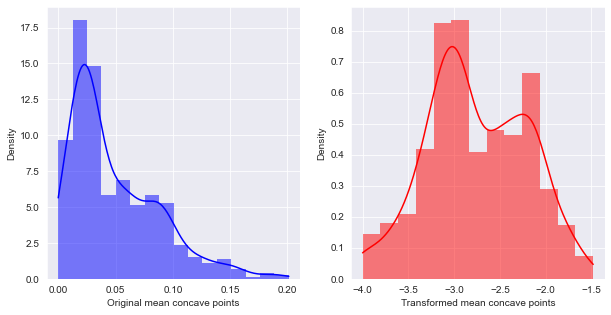


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'mean symmetry' . Skewness = 0.73


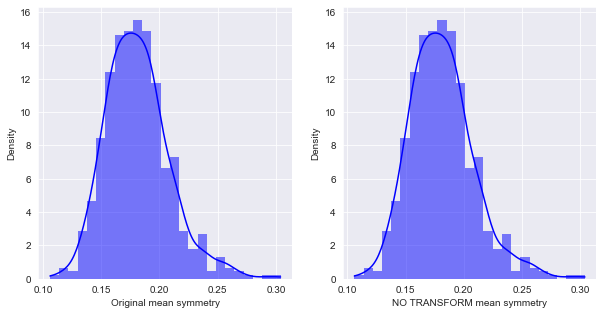


 ------------------------------------------------------

 'mean fractal dimension' had 'positive' skewness of 1.30

 Transformation yielded skewness of 0.01


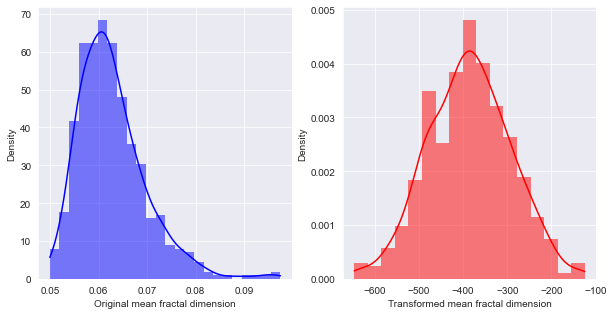


 ------------------------------------------------------

 'radius error' had 'positive' skewness of 3.09

 Transformation yielded skewness of 0.03


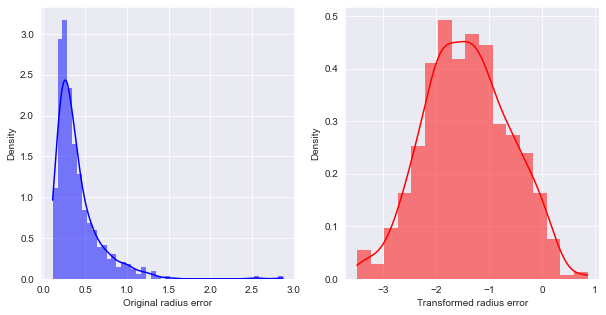


 ------------------------------------------------------

 'texture error' had 'positive' skewness of 1.65

 Transformation yielded skewness of -0.00


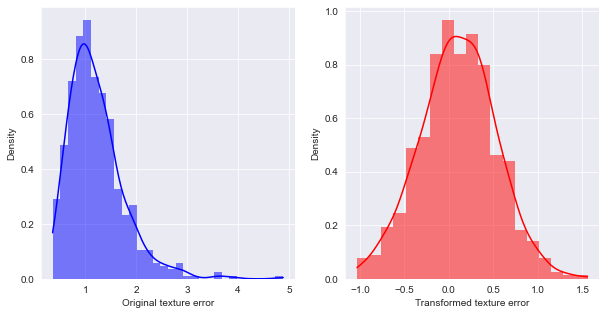


 ------------------------------------------------------

 'perimeter error' had 'positive' skewness of 3.44

 Transformation yielded skewness of 0.03


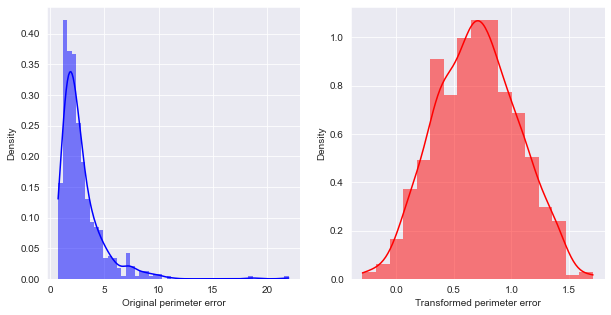


 ------------------------------------------------------

 'area error' had 'positive' skewness of 5.45

 Transformation yielded skewness of 0.06


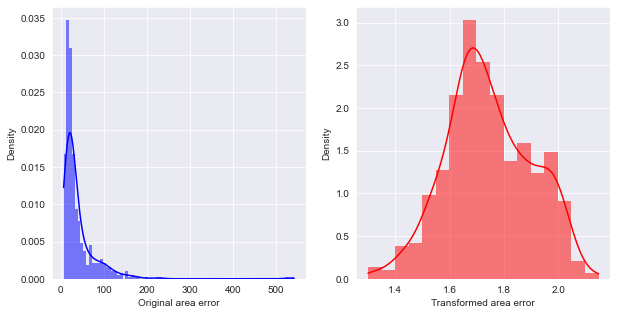


 ------------------------------------------------------

 'smoothness error' had 'positive' skewness of 2.31

 Transformation yielded skewness of -0.02


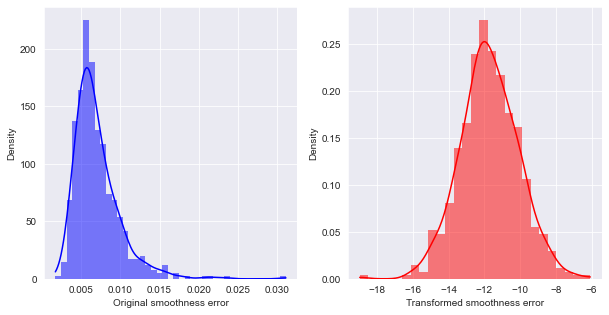


 ------------------------------------------------------

 'compactness error' had 'positive' skewness of 1.90

 Transformation yielded skewness of -0.00


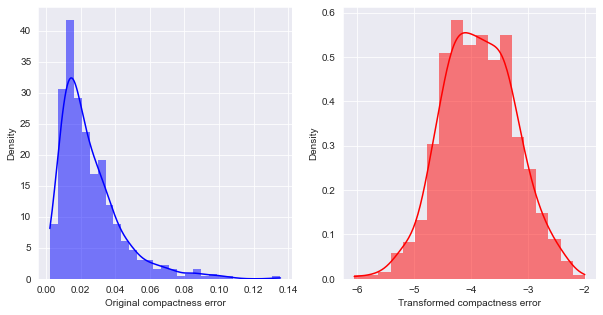


 ------------------------------------------------------

 'concavity error' had 'positive' skewness of 5.11

 Transformation yielded skewness of -0.01


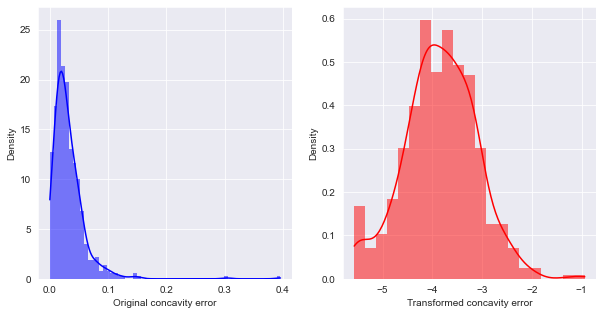


 ------------------------------------------------------

 'concave points error' had 'positive' skewness of 1.44

 Transformation yielded skewness of -0.01


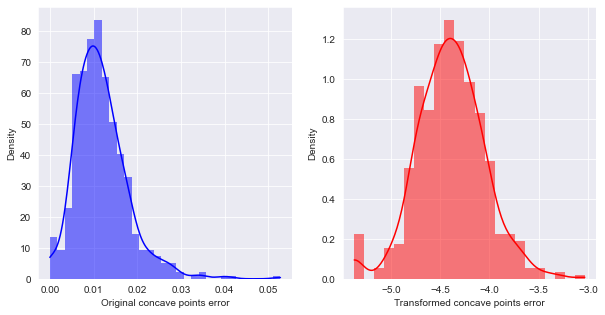


 ------------------------------------------------------

 'symmetry error' had 'positive' skewness of 2.20

 Transformation yielded skewness of 0.01


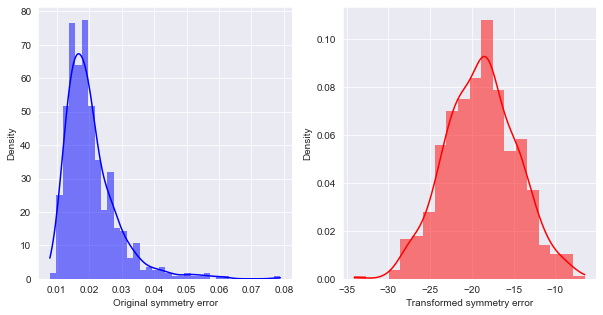


 ------------------------------------------------------

 'fractal dimension error' had 'positive' skewness of 3.92

 Transformation yielded skewness of -0.00


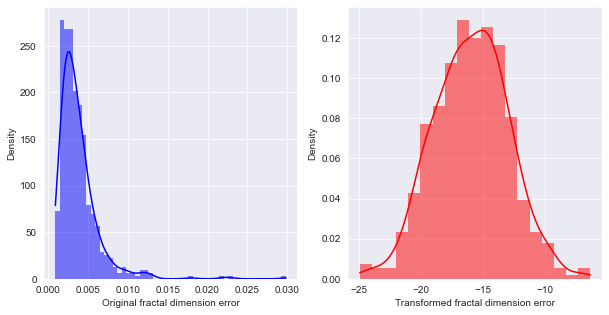


 ------------------------------------------------------

 'worst radius' had 'positive' skewness of 1.10

 Transformation yielded skewness of 0.03


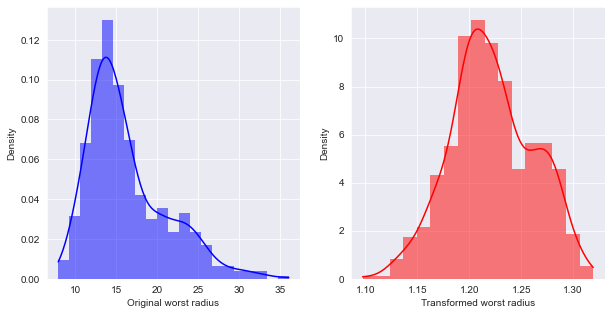


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'worst texture' . Skewness = 0.50


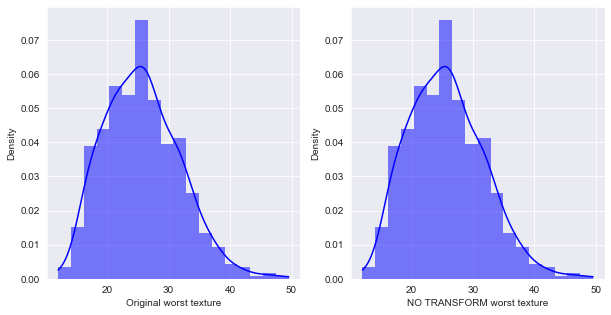


 ------------------------------------------------------

 'worst perimeter' had 'positive' skewness of 1.13

 Transformation yielded skewness of 0.03


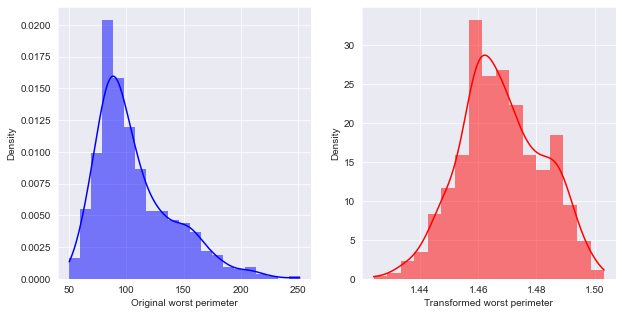


 ------------------------------------------------------

 'worst area' had 'positive' skewness of 1.86

 Transformation yielded skewness of 0.03


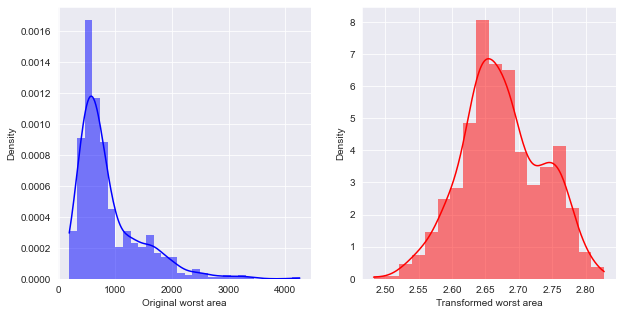


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'worst smoothness' . Skewness = 0.42


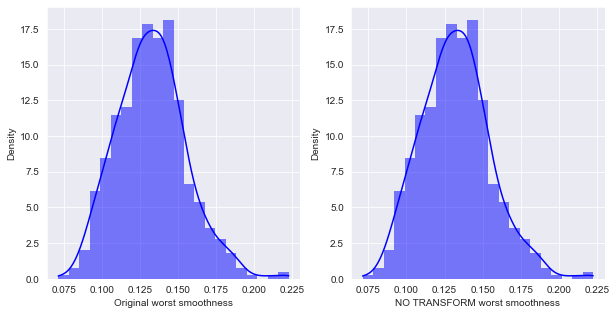


 ------------------------------------------------------

 'worst compactness' had 'positive' skewness of 1.47

 Transformation yielded skewness of -0.01


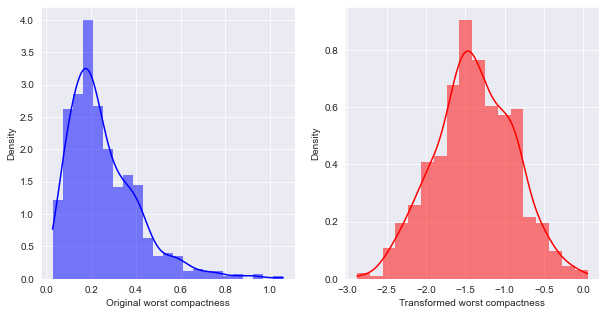


 ------------------------------------------------------

 'worst concavity' had 'positive' skewness of 1.15

 Transformation yielded skewness of -0.06


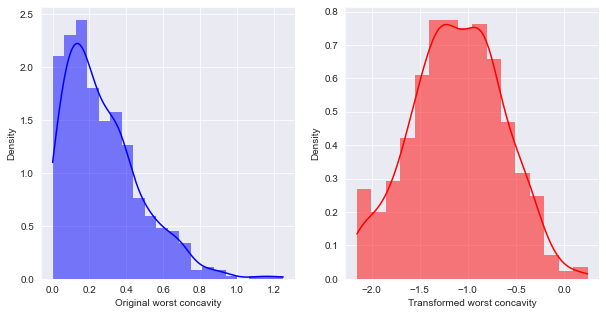


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'worst concave points' . Skewness = 0.49


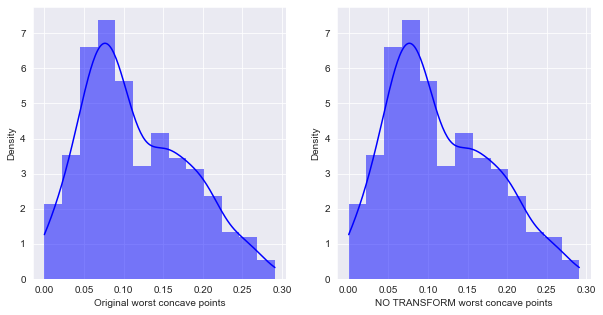


 ------------------------------------------------------

 'worst symmetry' had 'positive' skewness of 1.43

 Transformation yielded skewness of -0.03


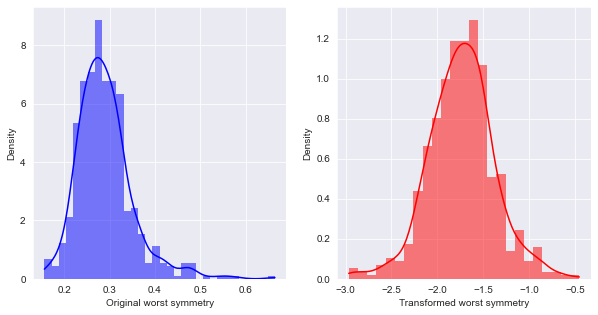


 ------------------------------------------------------

 'worst fractal dimension' had 'positive' skewness of 1.66

 Transformation yielded skewness of 0.02


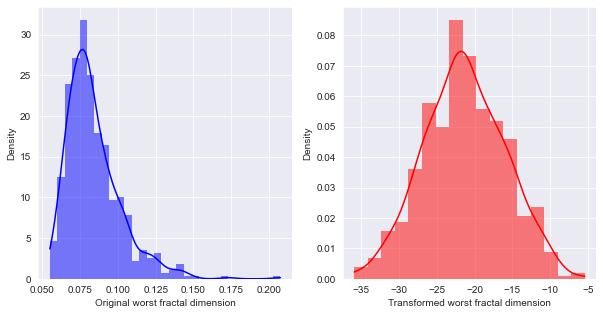

In [9]:
# Use code above (adapted from https://github.com/datamadness/Automatic-skewness-transformation-for-Pandas-DataFrame) to correct skewness
X = skew_autotransform(df.copy(deep=True), plot = True, exp = False, threshold = 1)

#**Outliers**

Column  target :  []
Column  mean radius :  [82, 108, 122, 164, 180, 202, 212, 236, 272, 339, 352, 368, 369, 393, 461, 503, 521, 564]
Column  mean texture :  [219, 232, 239, 259, 265, 455, 562]
Column  mean perimeter :  [82, 108, 122, 164, 180, 202, 212, 236, 272, 339, 352, 369, 393, 461, 503, 521]
Column  mean area :  [101, 212, 461, 538, 539, 568]
Column  mean smoothness :  [3, 105, 122, 504, 520, 568]
Column  mean compactness :  [178]
Column  mean concavity :  []
Column  mean concave points :  []
Column  mean symmetry :  [3, 22, 25, 60, 78, 108, 122, 146, 150, 152, 258, 288, 323, 424, 561]
Column  mean fractal dimension :  [3, 277]
Column  radius error :  [212]
Column  texture error :  [12, 192, 473, 561]
Column  perimeter error :  []
Column  area error :  []
Column  smoothness error :  [116, 122, 149, 192, 213, 263, 314, 489, 505]
Column  compactness error :  [178, 190, 315]
Column  concavity error :  [68, 152]
Column  concave points error :  [12, 68, 101, 140, 152, 174, 175, 192, 

c:\Users\User\miniconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\User\miniconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\User\miniconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\User\miniconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\User\miniconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\User\miniconda3\lib\site-packages\numpy\lib\function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArra

After            target  mean radius  mean texture  mean perimeter   mean area  \
count  569.000000   569.000000    569.000000      569.000000  569.000000   
mean     0.627417    14.053968     19.217838       91.354534    3.495239   
std      0.483918     3.180805      3.898115       21.781108    0.115203   
min      0.000000     9.504000     13.080000       60.340000    3.288744   
25%      0.000000    11.700000     16.170000       75.170000    3.413962   
50%      1.000000    13.370000     18.840000       86.240000    3.487543   
75%      1.000000    15.780000     21.800000      104.100000    3.576776   
max      1.000000    20.580000     27.150000      135.900000    3.696532   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096103         -2.303507       -2.217871            -2.755824   
std           0.012455          0.433419        0.573979          

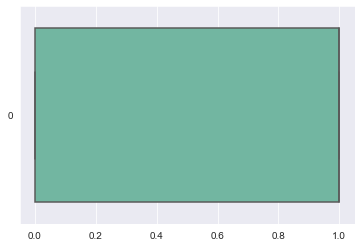

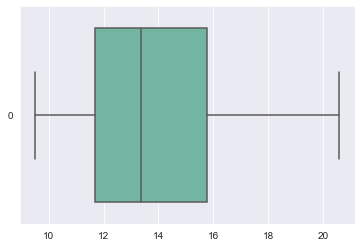

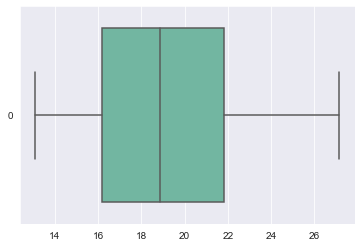

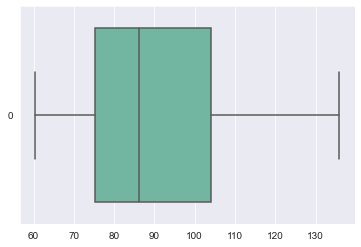

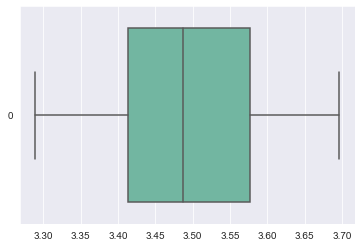

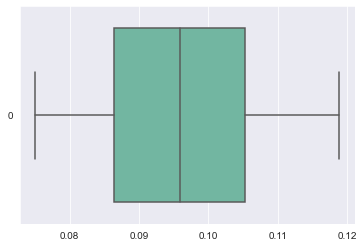

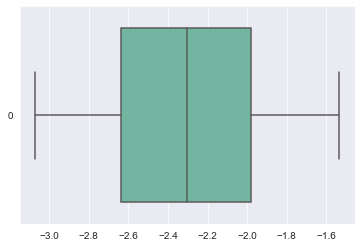

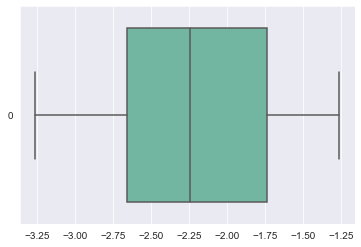

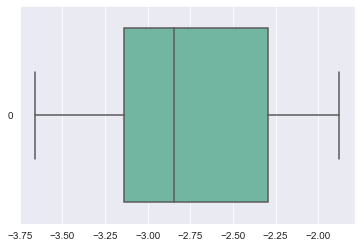

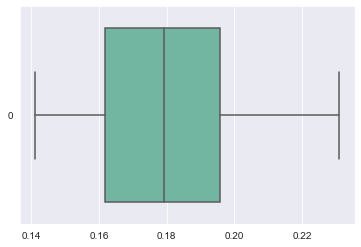

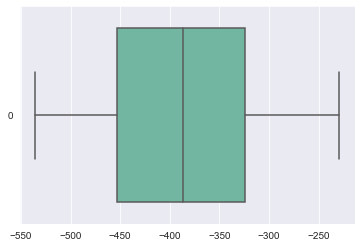

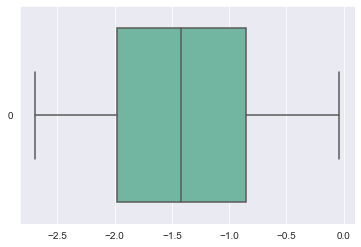

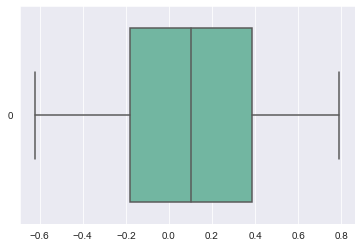

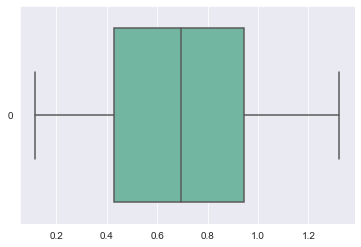

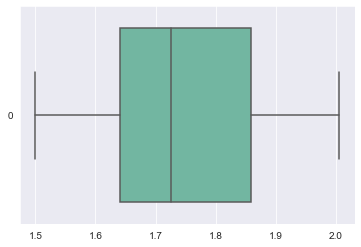

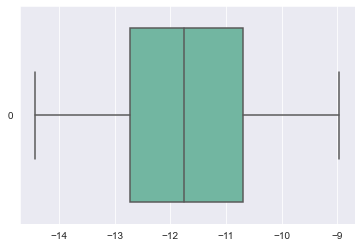

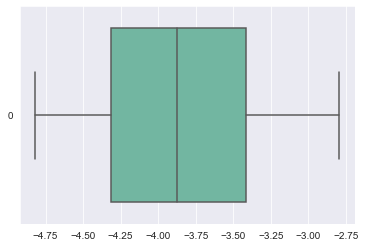

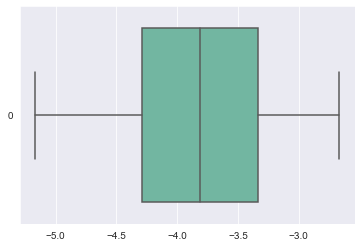

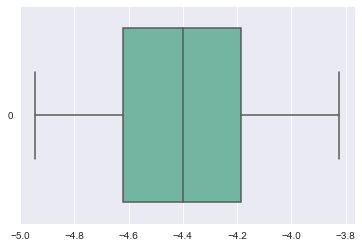

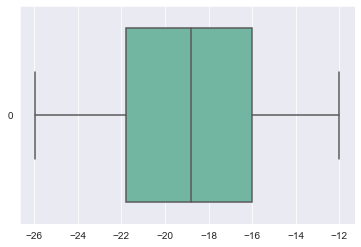

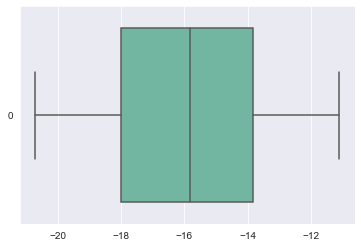

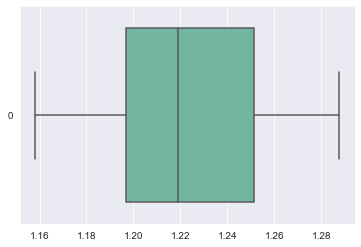

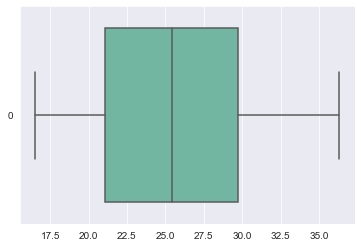

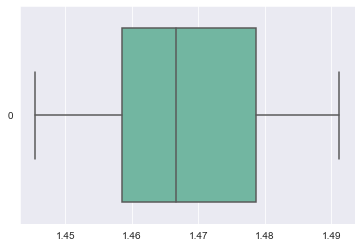

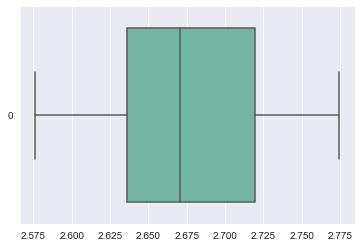

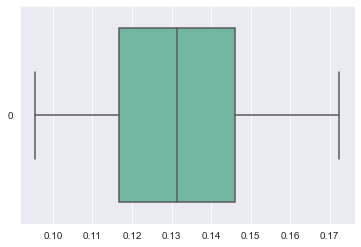

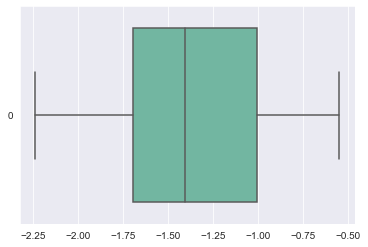

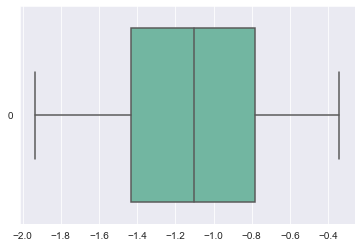

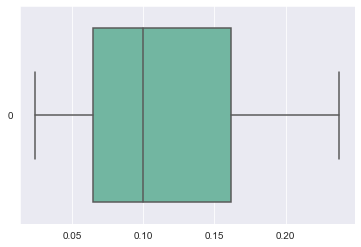

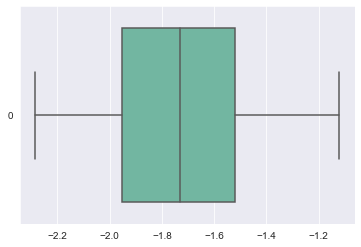

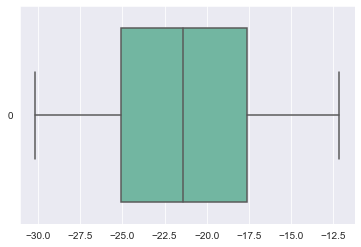

In [10]:
# Tukey Rule outliers
# As an alternative, you could use z-scores greater than 3 or less than -3.

cols = X.columns
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(X,i)
  print("Column ",i,": ",outliers_Tukey)
  
# Windsorize X and check the results
print("Before", X.describe())
X_winsorized = X.copy(deep=True)
for i in cols:
  X_winsorized[i] = winsorize(X[i], limits=(0.05, 0.05))
print("After", X_winsorized.describe())
for i in cols:
  ax = sns.boxplot(data=X_winsorized[i], orient="h", palette="Set2")
  plt.show()

Conclusions: target is unbalanced (approx 37% malignant). Oversampling may improve classifier performance. Many columns have high skewness meriting correction.

#**Holdout Sample**

Source: https://www.researchgate.net/publication/334119803_Secure_Learning_para_deteccion_de_Android_Malware/figures?lo=1
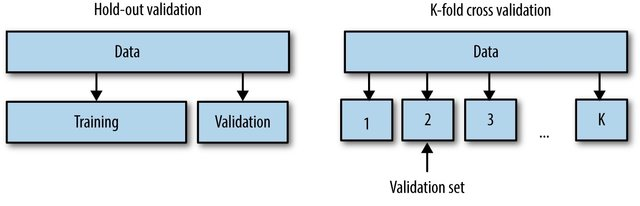

In [11]:
# Create holdout sample
# Note: split before doing any trasformations on the data!!!
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2,    # 80-20 training vs test set split
                     random_state=0, 
                     stratify=y)
print('Shape of X and y',X.shape, y.shape, '\nShape of training set X and y',X_train.shape, y_train.shape, '\nShape of test set X and y',X_test.shape, y_test.shape) 


Shape of X and y (569, 31) (569,) 
Shape of training set X and y (455, 31) (455,) 
Shape of test set X and y (114, 31) (114,)


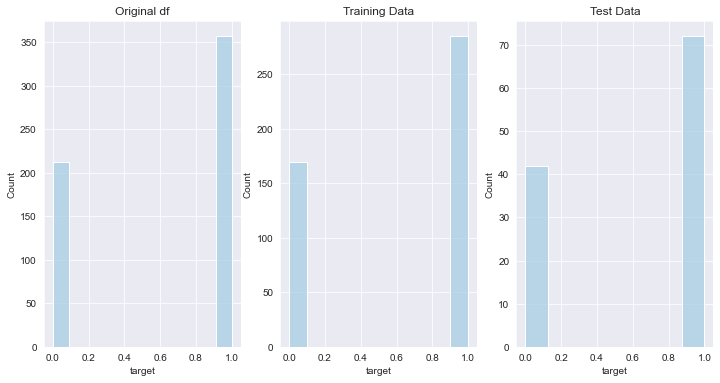

In [12]:
# Distribution of the target variable ('M')
plt.figure(figsize = (12,6))
plt.subplot(1,3,1)
sns.histplot(data=y).set_title("Original df")
plt.subplot(1,3,2)
sns.histplot(data=y_train).set_title("Training Data")
plt.subplot(1,3,3)
sns.histplot(data=y_test).set_title("Test Data")
plt.show()


#**Scaling**
* Standardizing involves the transformation of data into z-scores (by subtracting the feature mean and divding by the feature standard deviation). It's purpose is to ensure all features are on a common scale without distorting the relative differences between the instance values. Use standardizaition when there is no natural upper or lower bound for the feature in the use case.
* Normalization involves conversion of feature values to an interval (typically [0,1]). Use normalization when a feature has an upper and lower bound in the use case.


In [13]:
# Scaling:normalization or standardization
# SCALE AFTER SPLITTING TO AVOID DATA LEAKAGE!!!
# Scale quant features with bounds using Min-Max (normalizing) scaler, otherwise standardize

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Min-max scaler will not be used here based upon the assumption that all of the features are unbounded above.
# Min-max scaling(Normalization) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
#mms = MinMaxScaler()
#X_train_norm = mms.fit_transform(X_train)
#X_test_norm = mms.transform(X_test)
#print(X_train_norm)

# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()  #we fit the StandardScaler class only once—on the training data—and use those parameters to transform the test dataset or any new data point.
X_train_std = pd.DataFrame(stdsc.fit_transform(X_train))
X_test_std = pd.DataFrame(stdsc.transform(X_test))

print("Checking: mean of column 0 of X_train:",X_train_std[0].mean(), " and its std deviation:", X_train_std[0].std())

Checking: mean of column 0 of X_train: 3.9040809657148365e-17  and its std deviation: 1.0011007157982685


#**Logistic Regression Classifier**

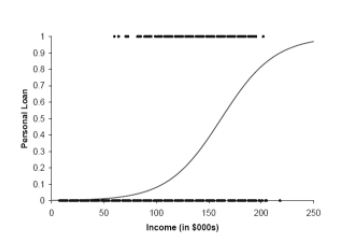

In [14]:
# Get started with logistic regression (logit) classifier
clm = LogisticRegression(random_state=1, solver='sag',max_iter=1000,class_weight='balanced')     # Create logit model specifying random number seed to get repeatable results, use sag solver as lbfgs does not converge
                                                                 # The following guidance about solvers is taken from the sklearn documentation:
                                                                 # For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
                                                                 # For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
                                                                 # ‘liblinear’ is limited to one-versus-rest schemes.

clm.fit(X_train_std, np.ravel(y_train))            # Fit model using training data. Ravel converts a column vector into the required 1D array format.
y_pred = clm.predict(X_test_std)                                 # Apply model to test data
print('Logit: AUC = ', roc_auc_score(y_test,y_pred), ' recall =', recall_score(y_test, y_pred),' accuracy = ', accuracy_score(y_test, y_pred))    # Test set accuracy
print(confusion_matrix(y_true=y_test,y_pred=y_pred))                           # Confusion matrix
print("Logit Model Coefficients",list(clm.coef_))                # Logistic coefficients (can be used to assess which variables have the largest effect size in the model)


Logit: AUC =  1.0  recall = 1.0  accuracy =  1.0
[[42  0]
 [ 0 72]]
Logit Model Coefficients [array([ 2.97343950e+00, -2.35934026e-01, -3.12682010e-01, -2.32486589e-01,
       -2.19256955e-01, -1.44938949e-01,  6.11769468e-02, -2.64656880e-01,
       -3.81896349e-01, -6.41212077e-02,  8.74236415e-02, -4.15423579e-01,
       -4.34262607e-02, -3.34516527e-01, -4.30491942e-01,  1.58699093e-01,
        2.56362716e-01,  2.91298995e-03, -1.85096687e-01,  2.88885978e-01,
        1.41519523e-01, -3.13631663e-01, -3.61565654e-01, -2.91870285e-01,
       -3.25747619e-01, -3.55110167e-01, -2.67236997e-02, -2.98569094e-01,
       -4.35770032e-01, -2.07775548e-01, -1.27745462e-01])]


In [15]:
# Examine propensities of logit model
logit_propensities = pd.DataFrame(clm.predict_proba(X_test_std)) 

# Create a dataframe showing actuals, predicted, and propensities 
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(drop = True , inplace = True)
y_test.reset_index(drop = True , inplace = True)
results = pd.concat([y_test, y_pred, logit_propensities[1]], axis=1)
results.columns= ['Actual','Predicted','Propensity']

#Compute percentage of instances with propensities in [lower_limit,upper_limit]
upper_limit = 0.7
lower_limit = 0.3
count = 0
for i in range(0,len(logit_propensities[1])):
  if((logit_propensities.loc[i,1] >= lower_limit) & (logit_propensities.loc[i,1] <= upper_limit)):
    count = count + 1
print('Percentage of test instances with propensity in [%1.2f, %1.2f]: %3.2f' % (lower_limit,upper_limit,100 * count/len(logit_propensities[1])))

# Show instances where predicted and actual differ
print('Instances for which actual and predicted differ:')
discrepancies = results.loc[results['Actual'] != results['Predicted']]
discrepancies


Percentage of test instances with propensity in [0.30, 0.70]: 0.00
Instances for which actual and predicted differ:


,Actual,Predicted,Propensity


In [16]:
results

,Actual,Predicted,Propensity
0,0.0,0.0,0.003614
1,0.0,0.0,0.000005
2,0.0,0.0,0.006165
3,1.0,1.0,0.996757
4,0.0,0.0,0.005978
...,...,...,...
109,0.0,0.0,0.001087
110,0.0,0.0,0.001149
111,1.0,1.0,0.982697
112,1.0,1.0,0.995643


Test Accuracy: 0.974
[[41  1]
 [ 2 70]]


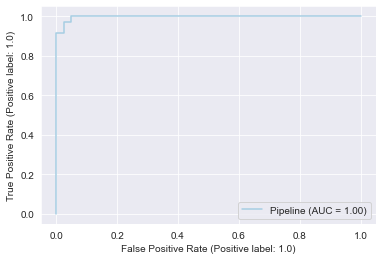

In [17]:
# In pursuit of a competitive model with a much smaller number of predictors, create a pipeline that scales, performs PCA, and fits and scores a logit model
# Use weights to a) offset the effect of the imbalance in the target column (212 M out of 569 total), and b) emphasize that a false negative may be much worse than a false positive

weights = {0:0.8, 1:0.2} # The weights are supposed to penalize errors in the classes. So, if we think false positives are 4 times "worse" than false negatives
                         # we should set the weights to be {0:0.2, 1:0.8}. But the implementation in sklearn appears to be backwards, so experiment with this  
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=5),
                        LogisticRegression(random_state=1,solver='sag',class_weight=weights))

pipe_lr.fit(X_train_std, np.ravel(y_train))
y_pred = pipe_lr.predict(X_test_std)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test_std, y_test))
print(confusion_matrix(y_test,y_pred,labels=[0,1]))                           # Confusion matrix
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
        pipe_lr, X_test_std, y_test,
    )


In [18]:
# Review propensities and misclassifications from PCA solution
pipe_lr_propensities = pd.DataFrame(clm.predict_proba(X_test_std)) 

# Create a dataframe showing actuals, predicted, and propensities 
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(drop = True , inplace = True)
y_test.reset_index(drop = True , inplace = True)
results = pd.concat([y_test, y_pred, pipe_lr_propensities[1]], axis=1)
results.columns= ['Actual','Predicted','Propensity']

#Compute percentage of instances with propensities in [lower_limit,upper_limit]
upper_limit = 0.7
lower_limit = 0.3
count = 0
for i in range(0,len(pipe_lr_propensities[1])):
  if((pipe_lr_propensities.loc[i,1] >= lower_limit) & (pipe_lr_propensities.loc[i,1] <= upper_limit)):
    count = count + 1
print('Percentage of test instances with propensity in [%1.2f, %1.2f]: %3.2f' % (lower_limit,upper_limit,100 * count/len(pipe_lr_propensities[1])))

# Show instances where predicted and actual differ
print('Instances for which actual and predicted differ:')
discrepancies = results.loc[results['Actual'] != results['Predicted']]
discrepancies


Percentage of test instances with propensity in [0.30, 0.70]: 0.00
Instances for which actual and predicted differ:


,Actual,Predicted,Propensity
42,1.0,0.0,0.926933
46,1.0,0.0,0.947320
54,0.0,1.0,0.142310


In [19]:
# Add cross-validation
weights = {0:0.2, 1:0.8} # The weights are supposed to penalize errors in the classes. So, if we think false positives are 4 times "worse" than false negatives
                         # we should set the weights to be {0:0.2, 1:0.8}. But the implementation in sklearn appears to be backwards, so experiment with this  
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=5),
                        LogisticRegression(random_state=1,solver='sag',class_weight=weights))

scores = cross_val_score(pipe_lr, X, y, cv=5, n_jobs = -1,scoring='roc_auc')
print('CV AUC scores: {}'.format(scores))
print('CV AUC mean: {} and std deviation: {}'.format(np.mean(scores), np.std(scores)))

scores = cross_val_score(pipe_lr, X, y, cv=5, n_jobs = -1,scoring='recall')
print('CV recall scores: {}'.format(scores))
print('CV recall mean: {} and std deviation: {}'.format(np.mean(scores), np.std(scores)))

scores = cross_val_score(pipe_lr, X, y, cv=5, n_jobs = -1)
print('CV accuracy scores: {}'.format(scores))
print('CV accuracy mean: {} and std deviation: {}'.format(np.mean(scores), np.std(scores)))

CV AUC scores: [0.99574189 0.99836227 0.99900794 0.98875661 1.        ]
CV AUC mean: 0.9963737420214656 and std deviation: 0.004061104123799618
CV recall scores: [1. 1. 1. 1. 1.]
CV recall mean: 1.0 and std deviation: 0.0
CV accuracy scores: [0.96491228 0.96491228 0.98245614 0.97368421 1.        ]
CV accuracy mean: 0.9771929824561404 and std deviation: 0.013128622409733122


#**Other Classifiers**

In [20]:
# Try other classifiers

names = ["Decision Tree", "k Nearest Neighbors", "SVM", "MLP", "Random Forest", "XGBoost", "Light GBM"]
classifiers = [ 
    DecisionTreeClassifier(max_depth=5),
    KNeighborsClassifier(3),
    SVC(),
    MLPClassifier(hidden_layer_sizes=(20,20),alpha=1, max_iter=500),
    RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=3),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

for name, clf in zip(names, classifiers):
  pipe_many = make_pipeline(StandardScaler(),
                        PCA(n_components=5),
                        clf)
  scores = cross_val_score(estimator=pipe_many,
                             X=X_train,
                             y=np.ravel(y_train),
                             cv=10,     #Reduced to three folds for execution speed
                             n_jobs=1,
                            scoring='roc_auc')
  print("Classifier: ",name)
  print('CV AUC scores: {}'.format(scores))
  print('CV AUC mean:{} and std:{}'.format(np.mean(scores), np.std(scores)))
  print("\n\n")

Classifier:  Decision Tree
CV AUC scores: [0.97058824 0.95334686 0.93407708 0.95334686 0.97058824 0.95168067
 0.91386555 0.96953782 0.92331933 0.96428571]
CV AUC mean:0.9504636337293538 and std:0.01930733833815585



Classifier:  k Nearest Neighbors
CV AUC scores: [0.9979716  0.9979716  0.98073022 0.96551724 0.97058824 1.
 1.         1.         0.99684874 1.        ]
CV AUC mean:0.9909627644161112 and std:0.01275491988299909



Classifier:  SVM
CV AUC scores: [1.         0.9979716  1.         1.         0.98377282 1.
 1.         1.         0.99789916 1.        ]
CV AUC mean:0.997964358157056 and std:0.004800113931400108



Classifier:  MLP
CV AUC scores: [1.         0.9979716  0.9979716  1.         0.99188641 1.
 1.         1.         0.99159664 1.        ]
CV AUC mean:0.9979426253259923 and std:0.0031991829696401105



Classifier:  Random Forest
CV AUC scores: [1.         0.9959432  0.9959432  0.9979716  0.96146045 1.
 0.99579832 1.         0.99369748 0.99579832]
CV AUC mean:0.9936612

#**Oversampling with SMOTE**

In [22]:
# Try SMOTE with cross validation using a logit model
# Borrowing code from https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', StandardScaler()],    
                                ['pca', PCA(n_components = 5)],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',    
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, np.ravel(y_train))
test_score = grid_search.score(X_test, y_test)

print(f'Test set ROC score: {test_score}')
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Test set ROC score: 0.9871031746031745
{'classifier__C': 0.1}
Pipeline(steps=[('smote', SMOTE(random_state=11)), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ['classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=11)]])


In [23]:
#Try other classifiers with SMOTE and cross validation
names = ["Decision Tree", "k Nearest Neighbors", "SVM", "MLP", "Random Forest", "XGBoost", "Light GBM"]
classifiers = [
    LogisticRegression(),   
    DecisionTreeClassifier(max_depth=5),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(20,20),alpha=1, max_iter=500),
    SVC(),
    RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=3),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

# Build each classifier using the unbalanced TRAINING data, show decision region and petrformance of the unbalanced TEST data 
no_folds = 5 # number of folds desired for cross validation
kf = StratifiedKFold(n_splits=no_folds, shuffle=True, random_state=12345)
for name, clf in zip(names, classifiers):
  print('CLASSIFIER: ',name,'\n')
  mean_accuracy = 0.0
  mean_recall = 0.0
  mean_auc = 0.0
  for fold, (train_index, test_index) in enumerate(kf.split(X,y),1):
    X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)] 
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, np.ravel(y_train))
    stdsc = StandardScaler()  
    X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)   
    X_test_std = stdsc.transform(X_test)  
    pca = PCA()
    X_train_pca=pca.fit_transform(X_train_SMOTE_std)
    X_test_pca=pca.transform(X_test_std)
    clf.fit(X_train_pca, np.ravel(y_train_SMOTE)) 
    y_pred = clf.predict(X_test_pca)
    print(f'For fold {fold}:')
    print(f'Accuracy: {clf.score(X_test_pca, y_test)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'AUC: {roc_auc_score(y_test, y_pred)}')
    mean_accuracy = mean_accuracy + clf.score(X_test_pca, y_test)
    mean_recall = mean_recall + recall_score(y_test, y_pred)
    mean_auc = mean_auc + roc_auc_score(y_test, y_pred)
  mean_accuracy = mean_accuracy / no_folds
  mean_recall = mean_recall / no_folds
  mean_auc = mean_auc / no_folds
  print('Average accuracy: %.3f Average recall: %.3f Average AUC: %.3f\n\n' % (mean_accuracy, mean_recall, mean_auc))

CLASSIFIER:  Decision Tree 

For fold 1:
Accuracy: 1.0
Recall: 1.0
AUC: 1.0
For fold 2:
Accuracy: 0.9912280701754386
Recall: 1.0
AUC: 0.9883720930232558
For fold 3:
Accuracy: 1.0
Recall: 1.0
AUC: 1.0
For fold 4:
Accuracy: 1.0
Recall: 1.0
AUC: 1.0
For fold 5:
Accuracy: 1.0
Recall: 1.0
AUC: 1.0
Average accuracy: 0.998 Average recall: 1.000 Average AUC: 0.998


CLASSIFIER:  k Nearest Neighbors 

For fold 1:
Accuracy: 0.9122807017543859
Recall: 0.9436619718309859
AUC: 0.9020635440550279
For fold 2:
Accuracy: 0.9122807017543859
Recall: 0.9436619718309859
AUC: 0.9020635440550279
For fold 3:
Accuracy: 0.9210526315789473
Recall: 0.9027777777777778
AUC: 0.9275793650793649
For fold 4:
Accuracy: 0.9210526315789473
Recall: 0.9166666666666666
AUC: 0.9226190476190476
For fold 5:
Accuracy: 0.9203539823008849
Recall: 0.9014084507042254
AUC: 0.9268947015425889
Average accuracy: 0.917 Average recall: 0.922 Average AUC: 0.916


CLASSIFIER:  SVM 

For fold 1:
Accuracy: 0.9736842105263158
Recall: 1.0
AUC: 

The leaderboard is now as follows:
Classifier performance results are ordered by AUC.

|**Classifier** |    AUC    |       Accuracy      |    Recall    |
|:----------------------|:------------:|:--------------:|:-------------:|
|Random Forest | 0.995 | 0.996 | 1 |
|Multilayer Perceptron | 0.998 | 0.998 | 1 |
|Decisiom Tree | 0.998 | 0.998 | 1 |
|Support Vector Machine | 0.992 | 0.993 | 0.997 |
|LightGBM | 0.976 |  0.977 | 0.981 |
|XGBoost | 0.969 | 0.972 | 0.980 |
|kNN | 0.922 | 0.923 | 0.924 |

Pick the RF model as the winner


In [24]:
# There are likely a number of classifiers in the Rashomon Set
# We'll pick the random forest model and optimize the hyperparameters

RF_params = {'criterion':['gini','entropy'],'max_depth':[7,10,15],'class_weight':[{0:0.1, 1:0.9}, {0:0.15, 1:0.85}, {0:0.2, 1:0.8}, {0:0.25, 1:0.75}]}
clf = GridSearchCV(RandomForestClassifier(oob_score=True), RF_params, cv=3,scoring='roc_auc')
clf.fit(X_train_SMOTE_std, np.ravel(y_train_SMOTE))
y_pred = clf.predict(X_test_std)
print(confusion_matrix(y_test, y_pred))
print(clf.best_params_, clf.best_score_)
print("Accuracy = ",accuracy_score(y_test, y_pred))
print("Recall = ",recall_score(y_test, y_pred))


[[42  0]
 [ 1 70]]
{'class_weight': {0: 0.15, 1: 0.85}, 'criterion': 'gini', 'max_depth': 10} 1.0
Accuracy =  0.9911504424778761
Recall =  0.9859154929577465


In [25]:
# Review propensities and misclassifications from PCA solution
clf = RandomForestClassifier(oob_score=True,class_weight= {0: 0.2, 1: 0.8}, criterion='gini',max_depth=7)
clf_propensities = pd.DataFrame(clf.fit(X_train_SMOTE_std, np.ravel(y_train_SMOTE)).predict_proba(X_test_std)) 

# Create a dataframe showing actuals, predicted, and propensities 
y_pred = pd.DataFrame(y_pred)
y_pred.reset_index(drop = True , inplace = True)
y_test.reset_index(drop = True , inplace = True)
results = pd.concat([y_test, y_pred, clf_propensities[1]], axis=1)
results.columns= ['Actual','Predicted','Propensity']

#Compute percentage of instances with propensities in [lower_limit,upper_limit]
upper_limit = 0.7
lower_limit = 0.3
count = 0
for i in range(0,len(clf_propensities[1])):
  if((clf_propensities.loc[i,1] >= lower_limit) & (clf_propensities.loc[i,1] <= upper_limit)):
    count = count + 1
print('Percentage of test instances with propensity in [%1.2f, %1.2f]: %3.2f' % (lower_limit,upper_limit,100 * count/len(clf_propensities[1])))

# Show instances where predicted and actual differ
print('Instances for which actual and predicted differ:')
discrepancies = results.loc[results['Actual'] != results['Predicted']]
discrepancies

Percentage of test instances with propensity in [0.30, 0.70]: 1.77
Instances for which actual and predicted differ:


,Actual,Predicted,Propensity
99,1.0,0.0,0.5


#**Conclusion**

Several models with AUC above 99% and recall above 95% were obtained. A random forest model was developed with AUC mean of 0.992, mean recall of 0.928, and mean accuracy of 0.73. A logistic regression model provided similar performance. 

We did not test the possibility that outliers (that we deleted) may end up actually helping our model. PCA and SMOTE offer small improvements. Techniques that seek better models for hard-to-classify instances may be needed to squeeze out FNs.
